In [ ]:
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

In [ ]:
# Transformaciones compatibles con ResNet18
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# ResNet18 preentrenada sin la última capa (solo extractor)
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Extraer características
features, labels = [], []

with torch.no_grad():
    for imgs, lbls in loader:
        out = model(imgs)                     # (batch, 512, 1, 1)
        out = out.view(out.size(0), -1)       # (batch, 512)
        features.append(out.numpy())
        labels.append(lbls.numpy())

# Unir y guardar
X = np.concatenate(features, axis=0)           # (n_samples, 512)
y = np.concatenate(labels, axis=0).reshape(-1, 1)

data = np.hstack((X, y))                       # Añadir etiquetas como última columna
df = pd.DataFrame(data)
df.to_csv("cifar10_resnet18_features_train.csv", index=False)

print("✅ Características extraídas y guardadas en 'cifar10_resnet18_features_train.csv'")

✅ Características extraídas y guardadas en 'cifar10_resnet18_features_train.csv'


In [ ]:
# Dataset test
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Extraer características
test_features, test_labels = [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        out = model(imgs)
        out = out.view(out.size(0), -1)
        test_features.append(out.numpy())
        test_labels.append(lbls.numpy())

# Guardar test
X_test = np.concatenate(test_features, axis=0)
y_test = np.concatenate(test_labels, axis=0).reshape(-1, 1)
data_test = np.hstack((X_test, y_test))

df_test = pd.DataFrame(data_test)
df_test.to_csv("cifar10_resnet18_features_test.csv", index=False)

print("✅ Test guardado en 'cifar10_resnet18_features_test.csv'")

✅ Test guardado en 'cifar10_resnet18_features_test.csv'


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Cargar CSVs
train_df = pd.read_csv('cifar10_resnet18_features_train.csv')
test_df = pd.read_csv('cifar10_resnet18_features_test.csv')

# Separar características y etiquetas
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (95% varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ya tienes en memoria:
# X_train_pca, y_train, X_test_pca, y_test para usar en clustering o modelos
print(f"Dimensiones después de PCA: {X_train_pca.shape}")
print(f"Dimensiones test después de PCA: {X_test_pca.shape}")

Dimensiones después de PCA: (50000, 283)
Dimensiones test después de PCA: (10000, 283)


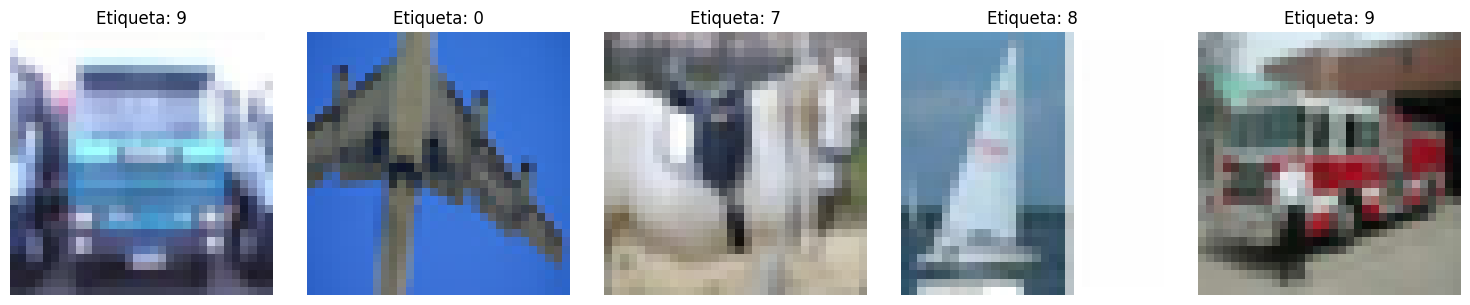

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

# Cargar los datos originales para visualizar las imágenes
cifar_data = CIFAR10(root='./data', train=True, transform=ToTensor(), download=False)

# Seleccionar 5 índices aleatorios
indices = random.sample(range(len(X_train)), 5)

# Crear figuras
plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    # Obtener la imagen original
    img, _ = cifar_data[idx]
    img = img.permute(1, 2, 0).numpy()  # Convertir de CxHxW a HxWxC
    label = int(y_train[idx])

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Etiqueta: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Silhouette scores for k=2 to k=19:
k=2: 0.0606
k=3: 0.0554
k=4: 0.0513
k=5: 0.0453
k=6: 0.0418
k=7: 0.0441
k=8: 0.0333
k=9: 0.0339
k=10: 0.0255
k=11: 0.0254
k=12: 0.0259
k=13: 0.0229
k=14: 0.0213
k=15: 0.0207
k=16: 0.0207
k=17: 0.0168
k=18: 0.0144
k=19: 0.0149
inertia for k=2 to k=19:
k=2: 24321174.6654
k=3: 22753844.9984
k=4: 22136758.6427
k=5: 21649259.8410
k=6: 21070071.0495
k=7: 20770615.9065
k=8: 20566196.5634
k=9: 20363268.2632
k=10: 20181104.7320
k=11: 19974672.0364
k=12: 19832121.4762
k=13: 19715573.7697
k=14: 19595136.9636
k=15: 19503020.0985
k=16: 19423479.8707
k=17: 19346182.2180
k=18: 19280883.3573
k=19: 19205623.2309
k=20: 19135568.9744


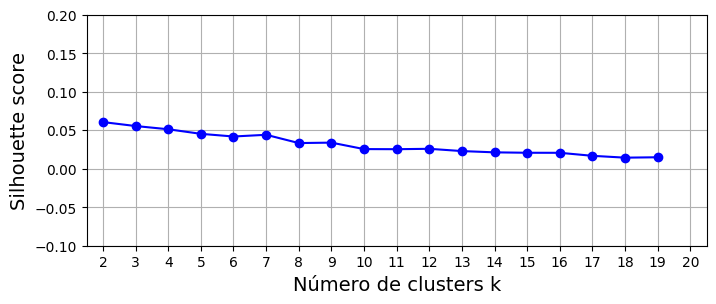

In [ ]:
# # metodo del codo

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
                for k in range(1, 20)]

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

from sklearn.cluster import KMeans

inertia = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)  # Usa tus datos preprocesados
    inertia.append(kmeans.inertia_)  # Guarda la inercia para k clusters


print("Silhouette scores for k=2 to k=19:")
for k, score in enumerate(silhouette_scores, start=2):
    print(f'k={k}: {score:.4f}')

print("inertia for k=2 to k=19:")
for k, score in enumerate(inertia, start=2):
    print(f'k={k}: {score:.4f}')

import matplotlib.pyplot as plt

# Plotting the silhouette scores
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("Número de clusters k", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.xticks(range(2, 21))  # Mostrar ticks de 1 en 1
plt.axis([1.5, 20.5, -0.1, .2])
plt.grid(True)
plt.show()

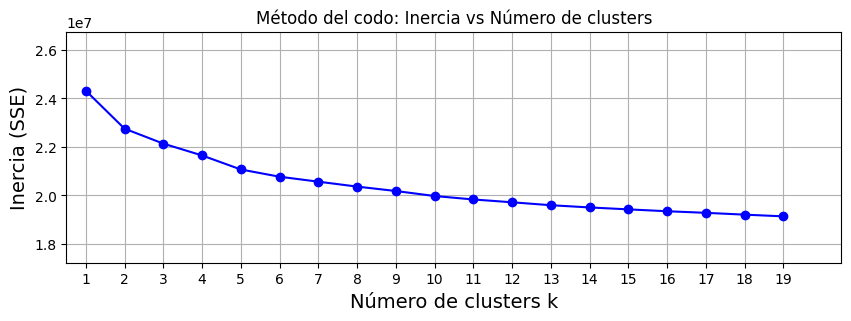

In [ ]:
import matplotlib.pyplot as plt

# Supongamos que tienes la lista 'inertia' calculada previamente para k=1 a 30
# inertia = [...]

plt.figure(figsize=(10, 3))
plt.plot(range(1, 20), inertia, "bo-")
plt.xlabel("Número de clusters k", fontsize=14)
plt.ylabel("Inercia (SSE)", fontsize=14)
plt.xticks(range(1, 20))  # Mostrar ticks de 1 en 1
plt.axis([0.5, 20.5, min(inertia)*0.9, max(inertia)*1.1])
plt.grid(True)
plt.title("Método del codo: Inercia vs Número de clusters")
plt.show()


In [ ]:
k = 10
# # entrenamos un modelo

# %%
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# %%
# Escalar características (recomendado para regresión logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Crear el modelo
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)

# Entrenar el modelo y medir tiempo (en Jupyter usar %time)
import time
start = time.time()
log_reg.fit(X_train_scaled, y_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end - start:.2f} segundos")

# %%
y_representative_digits = np.arange(1, k+1)

# %%
import numpy as np

# Entrenar un modelo de KMeans con k clusters
kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)

# Inicializar arreglo para etiquetas propagadas
y_train_propagated = np.empty(len(X_train), dtype=y_representative_digits.dtype)

# Propagar etiquetas según cluster
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

# Opcional: verificar resultados
print("Etiquetas propagadas:", np.unique(y_train_propagated))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Tiempo de entrenamiento: 9.86 segundos
Etiquetas propagadas: [ 1  2  3  4  5  6  7  8  9 10]


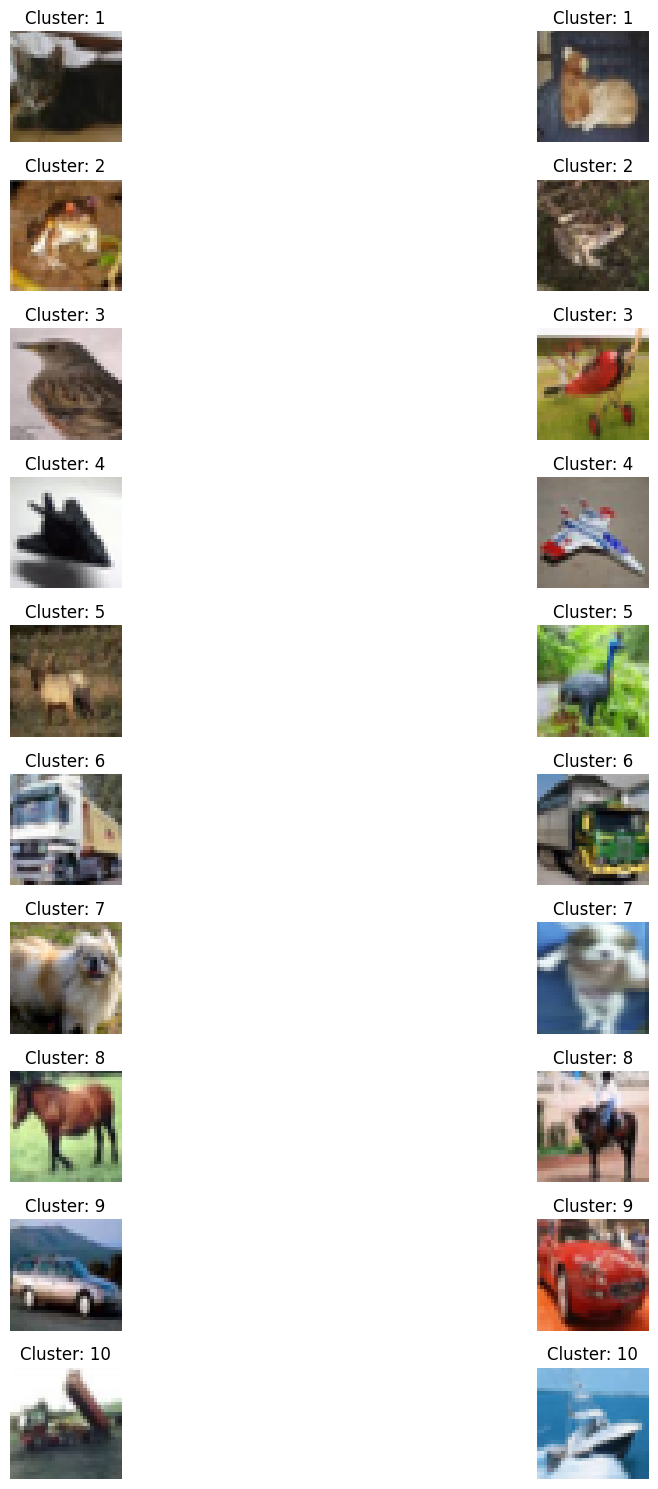

Etiquetas propagadas en test: [ 1  2  3  4  5  6  7  8  9 10]


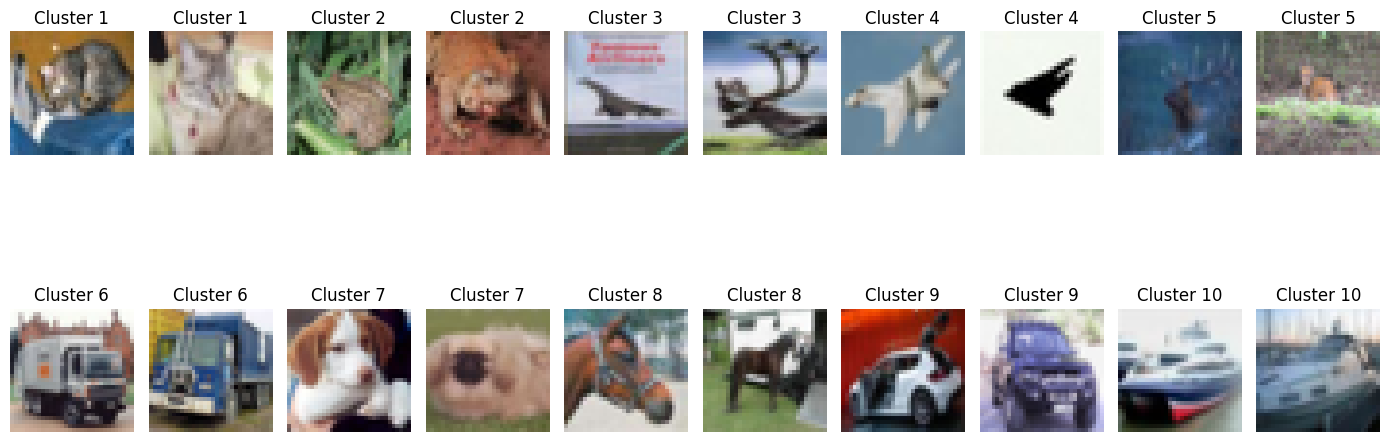

In [ ]:
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

# Cargar CIFAR-10 sin transformaciones (para obtener las imágenes reales)
dataset = CIFAR10(root='./data', train=True, download=False)

# Obtener los clusters únicos
clusters = np.unique(y_train_propagated)

# Crear una figura para mostrar 2 ejemplos por cluster
plt.figure(figsize=(15, 15))
for i, cluster in enumerate(clusters):
    # Encontrar todos los índices que pertenecen a este cluster
    cluster_indices = np.where(y_train_propagated == cluster)[0]

    # Tomar 2 ejemplos (o menos si no hay suficientes)
    num_examples = min(2, len(cluster_indices))
    sample_indices = cluster_indices[:num_examples]

    # Mostrar los ejemplos
    for j, idx in enumerate(sample_indices):
        img, _ = dataset[idx]
        plt.subplot(len(clusters), 2, i*2 + j + 1)
        plt.imshow(img)
        plt.title(f'Cluster: {cluster}')
        plt.axis('off')

plt.tight_layout()
plt.show()



# %%
# Predecir a qué cluster pertenece cada instancia del test
test_clusters = kmeans.predict(X_test_pca)

# Propagar etiquetas al test según el cluster
y_test_propagated = np.array([y_representative_digits[cluster] for cluster in test_clusters])

# Opcional: verificar resultados
print("Etiquetas propagadas en test:", np.unique(y_test_propagated))

# %%
import numpy as np

# Obtener los clusters predichos en test
test_clusters = kmeans.predict(X_test_pca)

# Lista para almacenar índices seleccionados
selected_indices = []

# Iterar sobre cada cluster
for cluster_id in range(k):
    # Obtener índices de instancias que pertenecen a este cluster
    cluster_indices = np.where(test_clusters == cluster_id)[0]

    # Tomar los primeros 2 (o menos si no hay suficientes)
    selected_indices.extend(cluster_indices[:2])

# Extraer imágenes originales del dataset CIFAR-10
# Cargar CIFAR-10 sin transformaciones (para obtener las imágenes reales)
test_dataset_original = CIFAR10(root='./data', train=False, download=False)
selected_labels = y_test_propagated[selected_indices]

# Visualizar las imágenes
plt.figure(figsize=(14, 7))
for i, (idx, label) in enumerate(zip(selected_indices, selected_labels)):
    # Obtener imagen original
    img, _ = test_dataset_original[idx]

    plt.subplot(2, len(selected_indices) // 2 + (1 if len(selected_indices) % 2 else 0), i + 1)
    plt.imshow(img)
    plt.title(f'Cluster {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# # aprendizaje activo

# %%
# Obtener las probabilidades predichas para las primeras 1000 imágenes del test
probas = log_reg.predict_proba(X_test_pca[:1000])

# Obtener el índice de la clase con mayor probabilidad para cada muestra
labels_ixs = np.argmax(probas, axis=1)

# Obtener la probabilidad (confianza) de la clase predicha para cada muestra
confidences = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])

# Ordenar los índices por menor confianza
sorted_ixs = np.argsort(confidences)

# Tomar los 10 con menor confianza
lowest_confidence_ixs = sorted_ixs[:10]

print("Confianzas más bajas:", confidences[lowest_confidence_ixs])


Confianzas más bajas: [0.16677908 0.16678558 0.16733622 0.16750693 0.16759508 0.16799176
 0.16830919 0.16853575 0.16894708 0.17103863]


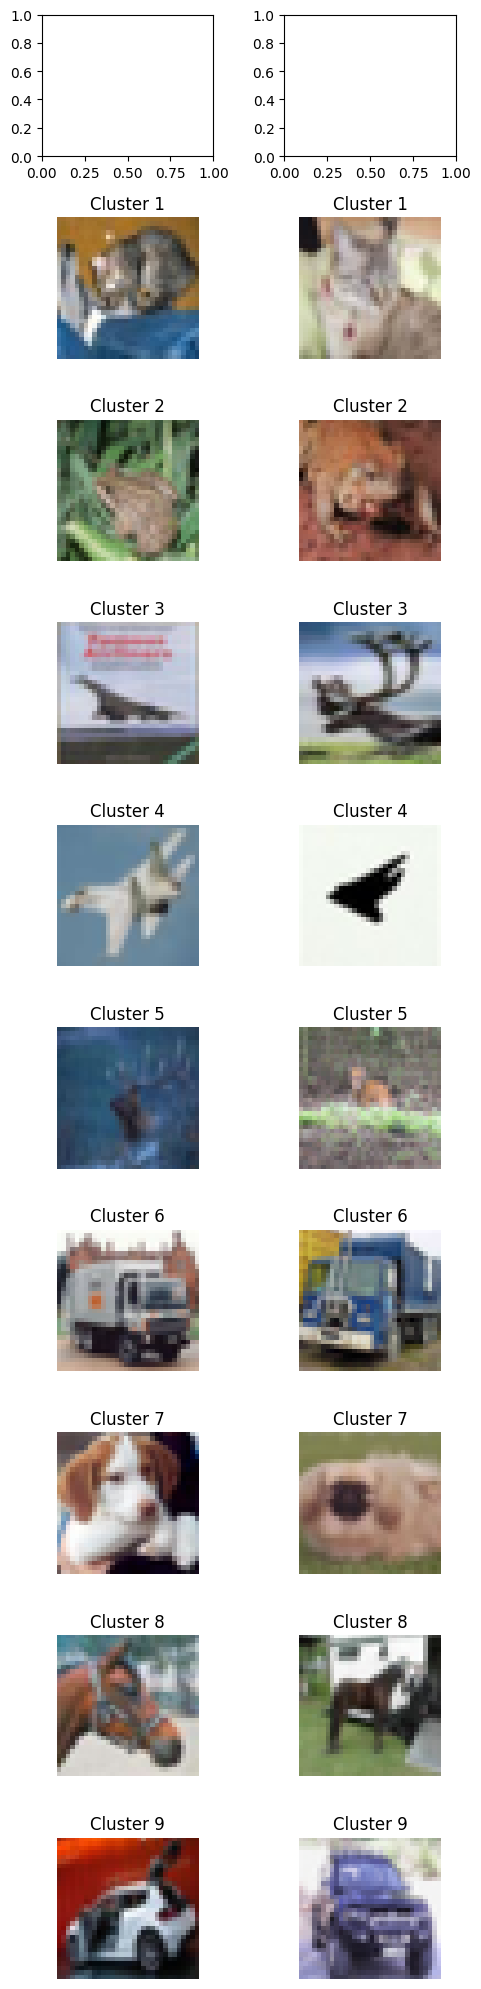

In [ ]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Cargar imágenes originales del test
transform = transforms.ToTensor()
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
X_test_orig = [img.numpy().transpose(1, 2, 0) for img, _ in test_dataset]  # de [C, H, W] a [H, W, C]

# Suponiendo que ya tienes y_test_propagated
k = len(np.unique(y_test_propagated))
fig, axs = plt.subplots(k, 2, figsize=(5, k * 2))

for cluster_id in range(k):
    idxs = np.where(y_test_propagated == cluster_id)[0][:2]
    for i, idx in enumerate(idxs):
        axs[cluster_id, i].imshow(X_test_orig[idx])
        axs[cluster_id, i].axis("off")
        axs[cluster_id, i].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()



In [ ]:
# Probabilidades de la predicción en test
probas = log_reg.predict_proba(X_test_pca)
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])

# Índices con las predicciones más seguras
sorted_ixs = np.argsort(-labels)  # De mayor a menor confianza

# Etiquetas propagadas más confiables
y_most_confident = y_test_propagated[sorted_ixs[:k]]
print(y_most_confident)

[3 4 7 7 7 7 3 7 3 4]


In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Supongo que ya tienes:
# X_train_pca, y_train_propagated (etiquetas propagadas),
# y_representative_digits (etiquetas reales corregidas para k clusters),
# sorted_ixs (índices de muestras con menor confianza),
# k (número de muestras para corregir por ciclo)

# Copiar etiquetas propagadas
y_train2 = y_train_propagated.copy()

# Corregir las k etiquetas con menor confianza (aprender con etiquetas reales)
y_train2[sorted_ixs[:k]] = y_representative_digits[:k]

# Entrenar modelo con las primeras 1000 muestras y etiquetas corregidas
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_pca[:], y_train2[:])

# Evaluar en test con etiquetas reales
accuracy = log_reg.score(X_test_pca, y_test)
print(f"Accuracy en test: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy en test: 0.0215


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Remapear etiquetas para que sean consecutivas desde 0
unique_labels = np.unique(y_train_propagated)
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

# Convertir etiquetas originales a índices desde 0
y_train_mapped = np.array([label_to_idx[label] for label in y_train_propagated])
y_test_mapped = np.array([label_to_idx.get(label, 0) for label in y_test])  # Usar 0 como valor predeterminado si no existe

# Convertir datos numpy a tensores PyTorch
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long)  # etiquetas remapeadas

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long)  # etiquetas remapeadas

# Dataset y DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir una red simple (ejemplo)
class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.fc(x)

# Instanciar red y optimizador
input_dim = X_train_pca.shape[1]
n_classes = len(unique_labels)  # Número de clases únicas después del remapeo

model = SimpleNN(input_dim, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento simple
epochs = 3
model.train()
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluación en test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Accuracy en test: {correct/total:.4f}")



# %%
from sklearn.ensemble import RandomForestClassifier

# Entrenar con primeros 1000 datos y etiquetas corregidas
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[:1000], y_train2[:1000])  # Use corresponding labels for the 1000 samples

# Evaluar en test
accuracy = rf.score(X_test, y_test)
print(f"Accuracy en test: {accuracy:.4f}")


Epoch 1/3, Loss: 0.1336
Epoch 2/3, Loss: 0.0613
Epoch 3/3, Loss: 0.0020
Accuracy en test: 0.0265
Accuracy en test: 0.0218
